In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Reinforcement Learning

- [openai gym](https://gym.openai.com/)

- No underlying information about the system is known
- Uses trial / error searching
- 'States'... where am I right now?
- 'Action'... what do I do?
- 'Rewards'... was it good?
- Assumes finite number of states, finite amount of actions
- Treated as a Markov process

# Creating Environment

In [2]:
env = gym.make('MountainCar-v0')
env.reset()


# getting the observation space (os)
# for mountain car, two values are [location, velocity]
print(env.observation_space.high)
print(env.observation_space.low)

# number of possible actions
print(env.action_space.n)



[0.6  0.07]
[-1.2  -0.07]
3


In [3]:

# since os is continuous, we need to bucket it
# bucket size is a hyper parameter we should try to optimize
bucket_os_size = [20] * len(env.observation_space.high)
bucket_window_size = (env.observation_space.high - env.observation_space.low) / bucket_os_size


# Q Values and Q Table

- Q is the expected reward for some action, a, in current state, s
- Expected reward is calculated by sum of all future rewards
- Q table has all the possible states, and within each state, the q value for each action
- Q table is the agent's 'policy'
- Bellman equation updates q values

In [17]:

# setting initial q table randomly. can also optimize this but more important to get the high/low right
low_q = -2
high_q = 0

# creating a bucket size (2d) x possible actions matrix with q values
q_table = np.random.uniform(low=low_q, high=high_q, size=(bucket_os_size + [env.action_space.n]))

# Params

In [18]:

# for tracking / monitoring
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'min': [], 'max': []}

# typically (0,1)
# can / should decay
# 1 is only learns, 0 is never learns
learning_rate = 0.1

# weight/discount for future actions
discount = 0.95

episodes = 10001
show_every = 500

# from (0,1), closer to 1 being more exploratory
# want this to decay
epsilon = 0.5
start_ep_decay = 1
end_ep_decay = episodes // 2  # the // always returns an int
ep_decay_value = epsilon / (end_ep_decay - start_ep_decay)



In [19]:
# since we have bucketed discrete states and the actions come back in continuous, need a helper function to bucket
def get_discrete_state(state):
    disc_state = (state - env.observation_space.low) / bucket_window_size
    return tuple(disc_state.astype(int))


# initial state
discrete_state = get_discrete_state(env.reset())


# q table for the initial state
print(q_table[discrete_state])
# best move
print(np.argmax(q_table[discrete_state]))



[-1.54525953 -0.66722913 -1.35306353]
1


# The Learning

The steps:

0. Initialize q table
1. Take an action in current state, moving to the next state
2. Calculate reward received for action plus q values in next state
3. Update q value for previous state

Repeat 1-3

In [20]:

for episode in range(episodes):
    episode_reward = 0
    # initial state
    discrete_state = get_discrete_state(env.reset())

    # if episode % show_every == 0:
    # if episode % show_every == 0:
    #    render = True
    #    print(episode)
    # else:
    #    render = False
    
    render = False
    done = False
    while not done:

        # which action to perform
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state])
        else:
            action = np.random.randint(0, env.action_space.n)

        # returning the updated state, reward, done, after taking the action
        new_state, reward, done, _ = env.step(action)
        episode_reward += reward
        new_discrete_state = get_discrete_state(new_state)

        if render:
            env.render()

        if not done:
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]

            # the q-learning equation
            new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        # if we reach the objective
        elif new_state[0] >= env.goal_position:
            q_table[discrete_state + (action,)] = 0
            print(f"Achieved on episode {episode}")

        discrete_state = new_discrete_state

    if end_ep_decay >= episode >= start_ep_decay:
        epsilon -= ep_decay_value

    ep_rewards.append(episode_reward)
    if not episode % show_every:  # same as if episode % show_every == 0
        avg_reward = sum(ep_rewards[-show_every:]) / len(ep_rewards[-show_every:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(avg_reward)
        aggr_ep_rewards['min'].append(min(ep_rewards[-show_every:]))
        aggr_ep_rewards['max'].append(max(ep_rewards[-show_every:]))

        print(f"Episode: {episode} | Avg: {avg_reward} | Min: {min(ep_rewards[-show_every:])} | Max: {max(ep_rewards[-show_every:])}")

        # saving the qtable
        np.save(f"qtables/{episode}-qtable.npy", q_table)
        
    
env.close()


Episode: 0 | Avg: -200.0 | Min: -200.0 | Max: -200.0
Episode: 500 | Avg: -200.0 | Min: -200.0 | Max: -200.0
Episode: 1000 | Avg: -200.0 | Min: -200.0 | Max: -200.0
Achieved on episode 1106
Achieved on episode 1131
Achieved on episode 1220
Achieved on episode 1241
Achieved on episode 1249
Achieved on episode 1253
Achieved on episode 1292
Achieved on episode 1375
Achieved on episode 1379
Achieved on episode 1489
Episode: 1500 | Avg: -199.652 | Min: -200.0 | Max: -169.0
Achieved on episode 1502
Achieved on episode 1525
Achieved on episode 1527
Achieved on episode 1528
Achieved on episode 1529
Achieved on episode 1532
Achieved on episode 1537
Achieved on episode 1544
Achieved on episode 1560
Achieved on episode 1565
Achieved on episode 1573
Achieved on episode 1581
Achieved on episode 1583
Achieved on episode 1584
Achieved on episode 1586
Achieved on episode 1587
Achieved on episode 1589
Achieved on episode 1591
Achieved on episode 1627
Achieved on episode 1633
Achieved on episode 1634
Ach

Achieved on episode 2889
Achieved on episode 2892
Achieved on episode 2895
Achieved on episode 2897
Achieved on episode 2898
Achieved on episode 2901
Achieved on episode 2914
Achieved on episode 2915
Achieved on episode 2921
Achieved on episode 2924
Episode: 3000 | Avg: -193.494 | Min: -200.0 | Max: -149.0
Achieved on episode 3023
Achieved on episode 3028
Achieved on episode 3029
Achieved on episode 3031
Achieved on episode 3032
Achieved on episode 3033
Achieved on episode 3035
Achieved on episode 3041
Achieved on episode 3043
Achieved on episode 3045
Achieved on episode 3047
Achieved on episode 3048
Achieved on episode 3051
Achieved on episode 3053
Achieved on episode 3054
Achieved on episode 3055
Achieved on episode 3056
Achieved on episode 3060
Achieved on episode 3062
Achieved on episode 3064
Achieved on episode 3065
Achieved on episode 3066
Achieved on episode 3067
Achieved on episode 3068
Achieved on episode 3069
Achieved on episode 3070
Achieved on episode 3071
Achieved on episo

Achieved on episode 3598
Achieved on episode 3599
Achieved on episode 3600
Achieved on episode 3601
Achieved on episode 3602
Achieved on episode 3604
Achieved on episode 3605
Achieved on episode 3606
Achieved on episode 3607
Achieved on episode 3608
Achieved on episode 3609
Achieved on episode 3610
Achieved on episode 3611
Achieved on episode 3612
Achieved on episode 3613
Achieved on episode 3614
Achieved on episode 3615
Achieved on episode 3616
Achieved on episode 3617
Achieved on episode 3619
Achieved on episode 3620
Achieved on episode 3621
Achieved on episode 3622
Achieved on episode 3623
Achieved on episode 3625
Achieved on episode 3626
Achieved on episode 3627
Achieved on episode 3628
Achieved on episode 3631
Achieved on episode 3633
Achieved on episode 3634
Achieved on episode 3639
Achieved on episode 3641
Achieved on episode 3643
Achieved on episode 3644
Achieved on episode 3645
Achieved on episode 3646
Achieved on episode 3647
Achieved on episode 3649
Achieved on episode 3654


Achieved on episode 4165
Achieved on episode 4166
Achieved on episode 4167
Achieved on episode 4168
Achieved on episode 4169
Achieved on episode 4170
Achieved on episode 4171
Achieved on episode 4172
Achieved on episode 4173
Achieved on episode 4174
Achieved on episode 4175
Achieved on episode 4176
Achieved on episode 4177
Achieved on episode 4178
Achieved on episode 4179
Achieved on episode 4180
Achieved on episode 4181
Achieved on episode 4182
Achieved on episode 4183
Achieved on episode 4184
Achieved on episode 4185
Achieved on episode 4186
Achieved on episode 4187
Achieved on episode 4188
Achieved on episode 4189
Achieved on episode 4190
Achieved on episode 4191
Achieved on episode 4192
Achieved on episode 4193
Achieved on episode 4194
Achieved on episode 4195
Achieved on episode 4196
Achieved on episode 4197
Achieved on episode 4198
Achieved on episode 4199
Achieved on episode 4200
Achieved on episode 4201
Achieved on episode 4202
Achieved on episode 4203
Achieved on episode 4204


Achieved on episode 4634
Achieved on episode 4635
Achieved on episode 4636
Achieved on episode 4637
Achieved on episode 4638
Achieved on episode 4639
Achieved on episode 4640
Achieved on episode 4641
Achieved on episode 4642
Achieved on episode 4645
Achieved on episode 4647
Achieved on episode 4648
Achieved on episode 4649
Achieved on episode 4650
Achieved on episode 4651
Achieved on episode 4652
Achieved on episode 4653
Achieved on episode 4654
Achieved on episode 4656
Achieved on episode 4657
Achieved on episode 4658
Achieved on episode 4659
Achieved on episode 4660
Achieved on episode 4661
Achieved on episode 4662
Achieved on episode 4663
Achieved on episode 4664
Achieved on episode 4665
Achieved on episode 4666
Achieved on episode 4667
Achieved on episode 4668
Achieved on episode 4669
Achieved on episode 4670
Achieved on episode 4671
Achieved on episode 4672
Achieved on episode 4674
Achieved on episode 4675
Achieved on episode 4676
Achieved on episode 4677
Achieved on episode 4678


Achieved on episode 4969
Achieved on episode 4970
Achieved on episode 4971
Achieved on episode 4972
Achieved on episode 4973
Achieved on episode 4974
Achieved on episode 4975
Achieved on episode 4976
Achieved on episode 4977
Achieved on episode 4978
Achieved on episode 4979
Achieved on episode 4980
Achieved on episode 4981
Achieved on episode 4982
Achieved on episode 4983
Achieved on episode 4984
Achieved on episode 4985
Achieved on episode 4986
Achieved on episode 4987
Achieved on episode 4988
Achieved on episode 4989
Achieved on episode 4990
Achieved on episode 4991
Achieved on episode 4992
Achieved on episode 4993
Achieved on episode 4994
Achieved on episode 4995
Achieved on episode 4996
Achieved on episode 4997
Achieved on episode 4998
Achieved on episode 4999
Achieved on episode 5000
Episode: 5000 | Avg: -161.872 | Min: -200.0 | Max: -112.0
Achieved on episode 5001
Achieved on episode 5002
Achieved on episode 5004
Achieved on episode 5005
Achieved on episode 5006
Achieved on episo

Achieved on episode 5311
Achieved on episode 5314
Achieved on episode 5315
Achieved on episode 5316
Achieved on episode 5317
Achieved on episode 5319
Achieved on episode 5323
Achieved on episode 5326
Achieved on episode 5327
Achieved on episode 5328
Achieved on episode 5329
Achieved on episode 5330
Achieved on episode 5331
Achieved on episode 5332
Achieved on episode 5333
Achieved on episode 5334
Achieved on episode 5336
Achieved on episode 5338
Achieved on episode 5339
Achieved on episode 5340
Achieved on episode 5341
Achieved on episode 5342
Achieved on episode 5345
Achieved on episode 5346
Achieved on episode 5347
Achieved on episode 5348
Achieved on episode 5349
Achieved on episode 5350
Achieved on episode 5351
Achieved on episode 5352
Achieved on episode 5353
Achieved on episode 5354
Achieved on episode 5355
Achieved on episode 5356
Achieved on episode 5357
Achieved on episode 5358
Achieved on episode 5359
Achieved on episode 5360
Achieved on episode 5361
Achieved on episode 5362


Achieved on episode 5657
Achieved on episode 5658
Achieved on episode 5659
Achieved on episode 5660
Achieved on episode 5661
Achieved on episode 5662
Achieved on episode 5663
Achieved on episode 5664
Achieved on episode 5665
Achieved on episode 5666
Achieved on episode 5667
Achieved on episode 5668
Achieved on episode 5669
Achieved on episode 5670
Achieved on episode 5671
Achieved on episode 5672
Achieved on episode 5673
Achieved on episode 5674
Achieved on episode 5675
Achieved on episode 5676
Achieved on episode 5677
Achieved on episode 5678
Achieved on episode 5680
Achieved on episode 5681
Achieved on episode 5682
Achieved on episode 5683
Achieved on episode 5684
Achieved on episode 5685
Achieved on episode 5686
Achieved on episode 5687
Achieved on episode 5688
Achieved on episode 5689
Achieved on episode 5690
Achieved on episode 5691
Achieved on episode 5693
Achieved on episode 5694
Achieved on episode 5695
Achieved on episode 5696
Achieved on episode 5699
Achieved on episode 5701


Achieved on episode 5998
Achieved on episode 5999
Achieved on episode 6000
Episode: 6000 | Avg: -161.204 | Min: -200.0 | Max: -108.0
Achieved on episode 6001
Achieved on episode 6002
Achieved on episode 6003
Achieved on episode 6004
Achieved on episode 6005
Achieved on episode 6006
Achieved on episode 6007
Achieved on episode 6008
Achieved on episode 6009
Achieved on episode 6010
Achieved on episode 6011
Achieved on episode 6012
Achieved on episode 6013
Achieved on episode 6014
Achieved on episode 6015
Achieved on episode 6016
Achieved on episode 6017
Achieved on episode 6018
Achieved on episode 6019
Achieved on episode 6020
Achieved on episode 6021
Achieved on episode 6022
Achieved on episode 6023
Achieved on episode 6024
Achieved on episode 6025
Achieved on episode 6026
Achieved on episode 6027
Achieved on episode 6028
Achieved on episode 6029
Achieved on episode 6030
Achieved on episode 6031
Achieved on episode 6032
Achieved on episode 6033
Achieved on episode 6034
Achieved on episo

Achieved on episode 6331
Achieved on episode 6332
Achieved on episode 6333
Achieved on episode 6334
Achieved on episode 6335
Achieved on episode 6336
Achieved on episode 6337
Achieved on episode 6338
Achieved on episode 6339
Achieved on episode 6340
Achieved on episode 6341
Achieved on episode 6342
Achieved on episode 6343
Achieved on episode 6344
Achieved on episode 6345
Achieved on episode 6346
Achieved on episode 6347
Achieved on episode 6348
Achieved on episode 6349
Achieved on episode 6350
Achieved on episode 6351
Achieved on episode 6352
Achieved on episode 6353
Achieved on episode 6354
Achieved on episode 6355
Achieved on episode 6356
Achieved on episode 6357
Achieved on episode 6358
Achieved on episode 6359
Achieved on episode 6360
Achieved on episode 6361
Achieved on episode 6362
Achieved on episode 6363
Achieved on episode 6364
Achieved on episode 6365
Achieved on episode 6366
Achieved on episode 6367
Achieved on episode 6368
Achieved on episode 6369
Achieved on episode 6370


Achieved on episode 6708
Achieved on episode 6709
Achieved on episode 6710
Achieved on episode 6711
Achieved on episode 6712
Achieved on episode 6713
Achieved on episode 6714
Achieved on episode 6716
Achieved on episode 6717
Achieved on episode 6718
Achieved on episode 6719
Achieved on episode 6721
Achieved on episode 6722
Achieved on episode 6723
Achieved on episode 6724
Achieved on episode 6725
Achieved on episode 6726
Achieved on episode 6727
Achieved on episode 6728
Achieved on episode 6729
Achieved on episode 6730
Achieved on episode 6731
Achieved on episode 6732
Achieved on episode 6733
Achieved on episode 6734
Achieved on episode 6735
Achieved on episode 6736
Achieved on episode 6737
Achieved on episode 6738
Achieved on episode 6739
Achieved on episode 6741
Achieved on episode 6742
Achieved on episode 6743
Achieved on episode 6744
Achieved on episode 6745
Achieved on episode 6746
Achieved on episode 6747
Achieved on episode 6748
Achieved on episode 6749
Achieved on episode 6750


Achieved on episode 7042
Achieved on episode 7043
Achieved on episode 7044
Achieved on episode 7045
Achieved on episode 7046
Achieved on episode 7047
Achieved on episode 7048
Achieved on episode 7049
Achieved on episode 7050
Achieved on episode 7051
Achieved on episode 7052
Achieved on episode 7053
Achieved on episode 7054
Achieved on episode 7055
Achieved on episode 7056
Achieved on episode 7057
Achieved on episode 7058
Achieved on episode 7059
Achieved on episode 7060
Achieved on episode 7061
Achieved on episode 7062
Achieved on episode 7063
Achieved on episode 7064
Achieved on episode 7065
Achieved on episode 7066
Achieved on episode 7067
Achieved on episode 7068
Achieved on episode 7069
Achieved on episode 7070
Achieved on episode 7071
Achieved on episode 7072
Achieved on episode 7073
Achieved on episode 7075
Achieved on episode 7076
Achieved on episode 7077
Achieved on episode 7078
Achieved on episode 7079
Achieved on episode 7080
Achieved on episode 7082
Achieved on episode 7084


Achieved on episode 7419
Achieved on episode 7428
Achieved on episode 7432
Achieved on episode 7433
Achieved on episode 7434
Achieved on episode 7435
Achieved on episode 7436
Achieved on episode 7437
Achieved on episode 7438
Achieved on episode 7439
Achieved on episode 7440
Achieved on episode 7441
Achieved on episode 7442
Achieved on episode 7443
Achieved on episode 7444
Achieved on episode 7445
Achieved on episode 7446
Achieved on episode 7447
Achieved on episode 7448
Achieved on episode 7449
Achieved on episode 7450
Achieved on episode 7451
Achieved on episode 7452
Achieved on episode 7453
Achieved on episode 7454
Achieved on episode 7455
Achieved on episode 7456
Achieved on episode 7457
Achieved on episode 7458
Achieved on episode 7459
Achieved on episode 7460
Achieved on episode 7461
Achieved on episode 7462
Achieved on episode 7463
Achieved on episode 7464
Achieved on episode 7465
Achieved on episode 7466
Achieved on episode 7467
Achieved on episode 7468
Achieved on episode 7469


Achieved on episode 7788
Achieved on episode 7789
Achieved on episode 7790
Achieved on episode 7791
Achieved on episode 7792
Achieved on episode 7793
Achieved on episode 7794
Achieved on episode 7795
Achieved on episode 7796
Achieved on episode 7798
Achieved on episode 7800
Achieved on episode 7801
Achieved on episode 7802
Achieved on episode 7803
Achieved on episode 7804
Achieved on episode 7805
Achieved on episode 7806
Achieved on episode 7807
Achieved on episode 7808
Achieved on episode 7809
Achieved on episode 7810
Achieved on episode 7811
Achieved on episode 7812
Achieved on episode 7813
Achieved on episode 7814
Achieved on episode 7815
Achieved on episode 7816
Achieved on episode 7818
Achieved on episode 7819
Achieved on episode 7820
Achieved on episode 7821
Achieved on episode 7822
Achieved on episode 7823
Achieved on episode 7824
Achieved on episode 7825
Achieved on episode 7826
Achieved on episode 7827
Achieved on episode 7828
Achieved on episode 7829
Achieved on episode 7830


Achieved on episode 8125
Achieved on episode 8126
Achieved on episode 8127
Achieved on episode 8128
Achieved on episode 8129
Achieved on episode 8130
Achieved on episode 8131
Achieved on episode 8132
Achieved on episode 8133
Achieved on episode 8134
Achieved on episode 8135
Achieved on episode 8136
Achieved on episode 8137
Achieved on episode 8138
Achieved on episode 8139
Achieved on episode 8140
Achieved on episode 8141
Achieved on episode 8142
Achieved on episode 8143
Achieved on episode 8144
Achieved on episode 8145
Achieved on episode 8146
Achieved on episode 8147
Achieved on episode 8148
Achieved on episode 8149
Achieved on episode 8150
Achieved on episode 8151
Achieved on episode 8152
Achieved on episode 8153
Achieved on episode 8154
Achieved on episode 8155
Achieved on episode 8156
Achieved on episode 8157
Achieved on episode 8158
Achieved on episode 8159
Achieved on episode 8160
Achieved on episode 8161
Achieved on episode 8162
Achieved on episode 8163
Achieved on episode 8164


Achieved on episode 8464
Achieved on episode 8465
Achieved on episode 8466
Achieved on episode 8467
Achieved on episode 8468
Achieved on episode 8469
Achieved on episode 8470
Achieved on episode 8471
Achieved on episode 8472
Achieved on episode 8473
Achieved on episode 8474
Achieved on episode 8475
Achieved on episode 8476
Achieved on episode 8477
Achieved on episode 8478
Achieved on episode 8479
Achieved on episode 8480
Achieved on episode 8481
Achieved on episode 8482
Achieved on episode 8483
Achieved on episode 8484
Achieved on episode 8485
Achieved on episode 8486
Achieved on episode 8487
Achieved on episode 8488
Achieved on episode 8489
Achieved on episode 8490
Achieved on episode 8491
Achieved on episode 8492
Achieved on episode 8493
Achieved on episode 8494
Achieved on episode 8495
Achieved on episode 8496
Achieved on episode 8497
Achieved on episode 8498
Achieved on episode 8499
Achieved on episode 8500
Episode: 8500 | Avg: -146.78 | Min: -200.0 | Max: -114.0
Achieved on episod

Achieved on episode 8801
Achieved on episode 8802
Achieved on episode 8803
Achieved on episode 8804
Achieved on episode 8805
Achieved on episode 8806
Achieved on episode 8807
Achieved on episode 8808
Achieved on episode 8809
Achieved on episode 8810
Achieved on episode 8811
Achieved on episode 8812
Achieved on episode 8813
Achieved on episode 8814
Achieved on episode 8815
Achieved on episode 8816
Achieved on episode 8817
Achieved on episode 8818
Achieved on episode 8819
Achieved on episode 8820
Achieved on episode 8821
Achieved on episode 8822
Achieved on episode 8823
Achieved on episode 8824
Achieved on episode 8825
Achieved on episode 8826
Achieved on episode 8827
Achieved on episode 8828
Achieved on episode 8829
Achieved on episode 8830
Achieved on episode 8831
Achieved on episode 8832
Achieved on episode 8833
Achieved on episode 8834
Achieved on episode 8835
Achieved on episode 8836
Achieved on episode 8837
Achieved on episode 8838
Achieved on episode 8839
Achieved on episode 8840


Achieved on episode 9139
Achieved on episode 9140
Achieved on episode 9141
Achieved on episode 9142
Achieved on episode 9143
Achieved on episode 9144
Achieved on episode 9145
Achieved on episode 9146
Achieved on episode 9147
Achieved on episode 9148
Achieved on episode 9149
Achieved on episode 9150
Achieved on episode 9151
Achieved on episode 9152
Achieved on episode 9153
Achieved on episode 9154
Achieved on episode 9155
Achieved on episode 9156
Achieved on episode 9157
Achieved on episode 9158
Achieved on episode 9159
Achieved on episode 9160
Achieved on episode 9161
Achieved on episode 9162
Achieved on episode 9163
Achieved on episode 9164
Achieved on episode 9165
Achieved on episode 9166
Achieved on episode 9167
Achieved on episode 9168
Achieved on episode 9169
Achieved on episode 9170
Achieved on episode 9171
Achieved on episode 9172
Achieved on episode 9173
Achieved on episode 9174
Achieved on episode 9175
Achieved on episode 9176
Achieved on episode 9177
Achieved on episode 9178


Achieved on episode 9471
Achieved on episode 9472
Achieved on episode 9473
Achieved on episode 9474
Achieved on episode 9475
Achieved on episode 9476
Achieved on episode 9477
Achieved on episode 9478
Achieved on episode 9479
Achieved on episode 9480
Achieved on episode 9481
Achieved on episode 9482
Achieved on episode 9483
Achieved on episode 9484
Achieved on episode 9485
Achieved on episode 9486
Achieved on episode 9487
Achieved on episode 9488
Achieved on episode 9489
Achieved on episode 9490
Achieved on episode 9491
Achieved on episode 9492
Achieved on episode 9493
Achieved on episode 9494
Achieved on episode 9495
Achieved on episode 9496
Achieved on episode 9497
Achieved on episode 9498
Achieved on episode 9499
Achieved on episode 9500
Episode: 9500 | Avg: -143.554 | Min: -200.0 | Max: -119.0
Achieved on episode 9501
Achieved on episode 9502
Achieved on episode 9503
Achieved on episode 9504
Achieved on episode 9505
Achieved on episode 9506
Achieved on episode 9507
Achieved on episo

Achieved on episode 9807
Achieved on episode 9808
Achieved on episode 9809
Achieved on episode 9810
Achieved on episode 9811
Achieved on episode 9812
Achieved on episode 9813
Achieved on episode 9814
Achieved on episode 9815
Achieved on episode 9816
Achieved on episode 9817
Achieved on episode 9818
Achieved on episode 9819
Achieved on episode 9820
Achieved on episode 9821
Achieved on episode 9822
Achieved on episode 9823
Achieved on episode 9824
Achieved on episode 9825
Achieved on episode 9826
Achieved on episode 9827
Achieved on episode 9828
Achieved on episode 9829
Achieved on episode 9830
Achieved on episode 9831
Achieved on episode 9832
Achieved on episode 9833
Achieved on episode 9834
Achieved on episode 9835
Achieved on episode 9836
Achieved on episode 9837
Achieved on episode 9838
Achieved on episode 9839
Achieved on episode 9840
Achieved on episode 9841
Achieved on episode 9842
Achieved on episode 9843
Achieved on episode 9844
Achieved on episode 9845
Achieved on episode 9846


# Data

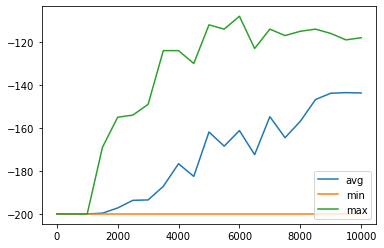

In [21]:

plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label='avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label='min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label='max')
plt.legend(loc=4)
plt.show()


In [22]:
q_table

array([[[-1.96678338e+00, -6.28343799e-01, -4.56260046e-01],
        [-4.43043565e+00, -3.25788962e+00, -5.31163400e+00],
        [-1.75966556e+01, -1.76111902e+01, -1.76056481e+01],
        ...,
        [-8.74534638e-01, -1.07718416e+00, -6.74048879e-01],
        [-2.42772584e-02, -6.96563719e-01, -1.10493636e+00],
        [-5.25242585e-01, -4.08407473e-01, -1.92419942e+00]],

       [[-1.64448821e-01, -1.48776425e+00, -3.63737582e-01],
        [-1.31559594e+01, -1.26750065e+01, -1.28809944e+01],
        [-1.78197814e+01, -1.78165439e+01, -1.78220161e+01],
        ...,
        [-4.32066234e-01, -1.08801310e+00, -1.17814515e+00],
        [-4.88500282e-01, -1.79034336e+00, -8.63114944e-01],
        [-1.40660062e+00, -1.82454448e-01, -1.07152593e+00]],

       [[-1.21545473e+00, -1.36266191e+00, -1.16516771e+00],
        [-1.76969578e+01, -1.77088389e+01, -1.76913440e+01],
        [-1.80382787e+01, -1.80773088e+01, -1.80842822e+01],
        ...,
        [-5.60339706e-01, -8.56758946e-01,